# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [2]:
con = mysql.connector.connect(user='root', password='B0984298936n',
                              host='127.0.0.1',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [3]:
cursor = con.cursor()
query = """
    SELECT MAX(hire_date) AS max_hire_date, MIN(hire_date) AS min_hire_date 
    FROM employees;
"""
cursor.execute(query)
results = cursor.fetchall()
print(results)
cursor.close()
con.close()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]


Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [4]:
import pandas as pd
con = mysql.connector.connect(user='root', password='B0984298936n',
                              host='127.0.0.1',
                              database='employees')
with con.cursor() as cursor:
    # Запит для отримання останньої зарплати
    query = """
    SELECT s.emp_no, s.salary, s.from_date, s.to_date
    FROM salaries s
    INNER JOIN (
        SELECT emp_no, MAX(to_date) AS last_to_date
        FROM salaries
        GROUP BY emp_no
    ) AS latest_salary
    ON s.emp_no = latest_salary.emp_no AND s.to_date = latest_salary.last_to_date
    """
    cursor.execute(query)
    
    # Запис результатів у pandas DataFrame
    res = pd.DataFrame(cursor.fetchall())

# Отримання назв колонок після виконання запиту
field_names = [i[0] for i in cursor.description]
res.columns = field_names  # Присвоєння назв колонок до DataFrame

# Виведення назв колонок, розміру DataFrame та перших 3 записів
print("Назви колонок:", res.columns.tolist())
print("Розмір DataFrame:", res.shape)
print("Перші 3 записи:")
print(res.head(3))

Назви колонок: ['emp_no', 'salary', 'from_date', 'to_date']
Розмір DataFrame: (300180, 4)
Перші 3 записи:
   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


In [5]:
field_names = [i[0] for i in cursor.description]

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [6]:
import pandas as pd
con = mysql.connector.connect(user='root', password='B0984298936n',
                              host='127.0.0.1',
                              database='employees')
cursor = con.cursor()

# SQL запит для отримання останньої зарплати кожного співробітника
query = """
    SELECT emp_no, salary, from_date, to_date
    FROM salaries AS s
    WHERE to_date = (
        SELECT MAX(to_date)
        FROM salaries
        WHERE emp_no = s.emp_no
    );
"""

cursor.execute(query)
res = pd.DataFrame(cursor.fetchall(), columns=[i[0] for i in cursor.description])

# Виведення результату
print(res.columns)
print(res.shape)
print(res.head(3))

# Закриття підключення
cursor.close()
con.close()



Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')
(300180, 4)
   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

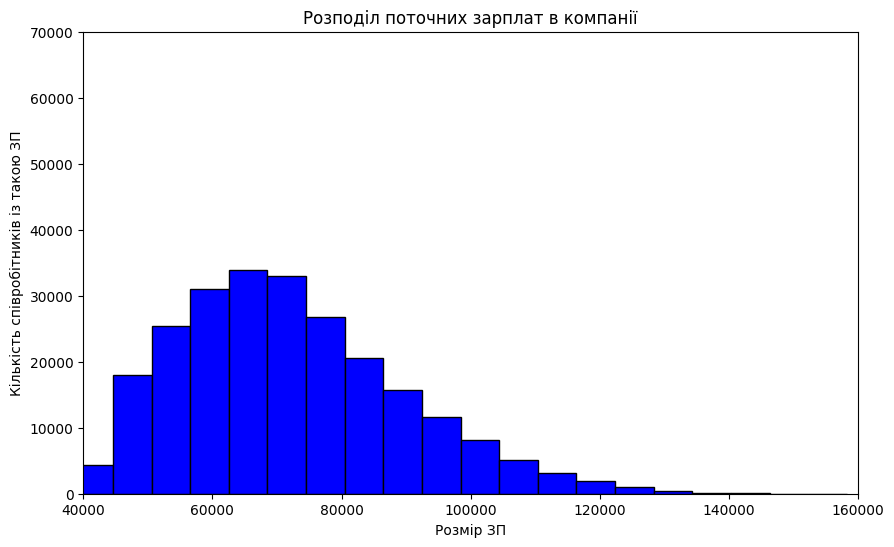

In [8]:
import matplotlib.pyplot as plt

# Фільтрація даних співробітників, які ще працюють в компанії
current_employees = res[res['to_date'] == '9999-01-01']

# Побудова гістограми із зарплатами співробітників
plt.figure(figsize=(10, 6))
plt.hist(current_employees['salary'], bins=20, color='blue', edgecolor='black')

# Додавання підписів
plt.xlabel('Розмір ЗП')
plt.ylabel('Кількість співробітників із такою ЗП')
plt.title('Розподіл поточних зарплат в компанії')

# Встановлення меж осей для відповідності очікуваному результату
plt.ylim(0, 70000)
plt.xlim(40000, 160000)

# Відображення графіку
plt.show()



Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [9]:
con.close()